<a href="https://colab.research.google.com/github/amazzoli/Quantitative_immunology/blob/main/notebooks/Noiset_3_detection_of_responding_clones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

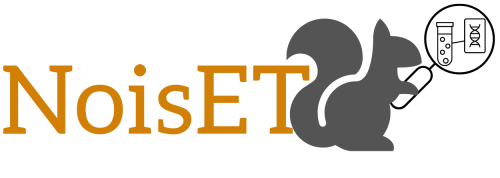

# Inferring responding immune clonotypes

In [ ]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#deciding format of the figures
plt.rc('xtick', labelsize = 25)
plt.rc('ytick', labelsize = 25)

## Part 3 - Inferring the contracted clonotypes

In [ ]:
# We are installing noisets to use it !
!pip install noisets

from noisets import noisettes as ns

In [ ]:
%%bash
git clone https://github.com/mbensouda/NoisET_tutorial.git

Cloning into 'NoisET_tutorial'...


### 3.1 - Loading data

For this analysis we will focus on the first time point, day 15, and day 45.
This tables are imported below using a noiset utility.

**Notice that by default noiset looks for expansion, while here we look for contraction. A simple trick for fixing this is just to invert the time points.**

In [ ]:
# Data information 
path = 'NoisET_tutorial/data/'
filename1 = 'MP_45_F1_short.zip' # sample for individual M at day 45 of the study
filename2 = 'MP_15_F1_short.zip' # sample for individual M at day 15 of the study
colnames1 = ['Clone fraction','Clone count', 'N. Seq. CDR3', 'AA. Seq. CDR3'] #colnames that will change if you work with a different data-set
colnames2 = ['Clone fraction','Clone count', 'N. Seq. CDR3', 'AA. Seq. CDR3'] # same as above

# check 
MP_contraction = ns.Data_Process(path, filename1, filename2, colnames1,  colnames2)
print("First Filename is : " , MP_contraction.filename1)
print("Second Filename is : ",  MP_contraction.filename2)
print("Name of the columns of first file are : ", MP_contraction.colnames1)
print("Name of the columns of second file are : ", MP_contraction.colnames2)

n, df_contraction = MP_contraction.import_data()

First Filename is :  MP_45_F1_short.zip
Second Filename is :  MP_15_F1_short.zip
Name of the columns of first file are :  ['Clone fraction', 'Clone count', 'N. Seq. CDR3', 'AA. Seq. CDR3']
Name of the columns of second file are :  ['Clone fraction', 'Clone count', 'N. Seq. CDR3', 'AA. Seq. CDR3']


/usr/local/lib/python3.7/dist-packages/noisets/noisettes.py:99: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  mergedFrame.drop(newnames[3]+suffixes[1], 1,inplace=True) #removes duplicates


In [ ]:
df_contraction

,Clone_fraction_1,Clone_fraction_2,Clone_count_1,Clone_count_2,ntCDR3,AACDR3
0,0.046930,4.600179e-02,106262.0,89845.0,TGTGCCAGCAGCGCCCCAGCGGGGGTCGGCGAGCAGTACTTC,CASSAPAGVGEQYF
1,0.039028,3.961802e-02,88368.0,77377.0,TGTGCCAGCAGCCCAAGGGCAGGGAAGGGTGAGCAGTTCTTC,CASSPRAGKGEQFF
2,0.020447,2.154908e-02,46296.0,42087.0,TGTGCCAGCAGCCCGCCGGGACAGCACAATGAGCAGTTCTTC,CASSPPGQHNEQFF
3,0.019505,2.572711e-02,44165.0,50247.0,TGTGCCAGCAGTTTTTGGACACCCTACGAGCAGTACTTC,CASSFWTPYEQYF
4,0.013851,1.603727e-02,31363.0,31322.0,TGTGCCAGCAGCTTGGAAGGGTACGGGACGCCGGCTGAAGCTTTCTTT,CASSLEGYGTPAEAFF
...,...,...,...,...,...,...
1199118,0.000000,5.120128e-07,0.0,1.0,TGTGCCAGCGGC,CASG
1199119,0.000000,5.120128e-07,0.0,1.0,TGTGCCAGCACC,CAST
1199120,0.000000,5.120128e-07,0.0,1.0,TGTACCCTGGGC,CTLG
1199121,0.000000,5.120128e-07,0.0,1.0,TGTAGACTCTTC,CRLF


(2.5e-07, 0.1, 2.5e-07, 0.1)

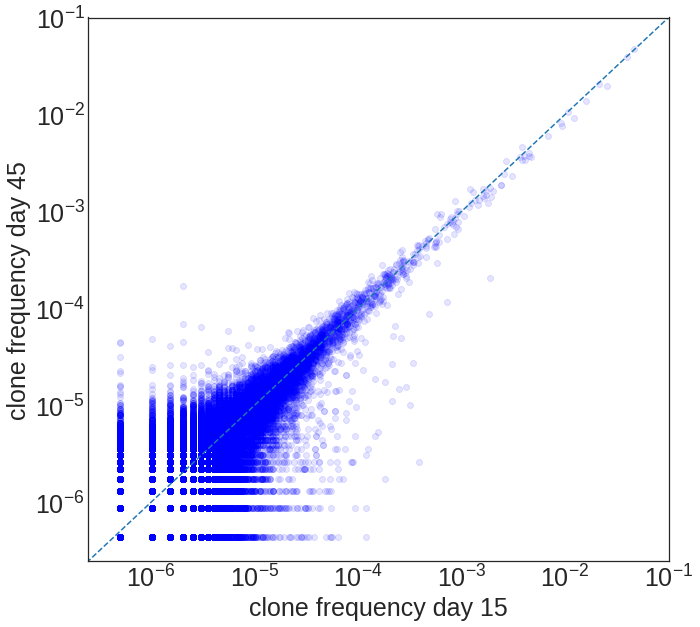

In [ ]:
plt.figure(figsize=(10.4,10))
X = np.linspace(0,1, 1000)

plt.style.use('seaborn-white')
plt.scatter(df_contraction['Clone_fraction_2'], df_contraction['Clone_fraction_1'], color='blue', alpha = 0.1)
plt.plot(X,X, linestyle ='--')
plt.xlabel(r'clone frequency day 15', fontsize = 25)
plt.ylabel(r'clone frequency day 45', fontsize = 25)
plt.xscale('log')
plt.yscale('log')
plt.axis([2.5e-7, 1e-1, 2.5e-7, 1e-1])


**Task 3.1** 
Plot in the same figure scatter plots showing the variability between replicates samples from the same day, and samples taken at two different time points (here day 15 and day 45).

### 3.2 Detection of contracting clones from day 15 to day 45

In [ ]:
#Parameters of the noise model learnt in part II.
paras = [ -1.97822857,   1.25456411,   1.04465803, -10.14630235]
# Negative Binomial Sampling Noise Model
noise_model = 1 

Below the noiset utility for identifying expanded clonotypes is run. 
Two parameters can be tuned : `pval_threshold` is a threshold that controls  the permissiveness of the method (playing somehow the role of the statistical significance) and `smed_threshold` instead can control the weight to give to large colonotypes in being significant. 


In [ ]:
expansion = ns.Expansion_Model() # Creating an object for which the associated methods are linked to the contraction/expansion
pval_threshold = 0.05  #Parameters to play with
smed_threshold = 0 # Parameters to play with

outpath = 'contracted_clones' # name of the file Chose what you want 

#Learn the contraction/expansion model + compute different statistics of the log-fold change variable + detect contracting clones
#This part should take approximatively 10 minutes
expansion.expansion_table(outpath, paras, paras, df_contraction, noise_model, pval_threshold, smed_threshold)

/usr/local/lib/python3.7/dist-packages/noisets/noisettes.py:520: RuntimeWarning: divide by zero encountered in true_divide
  NBvec=np.log((NBvec+r[:,np.newaxis]-1)*(p[:,np.newaxis]/NBvec))
/usr/local/lib/python3.7/dist-packages/noisets/noisettes.py:520: RuntimeWarning: invalid value encountered in log
  NBvec=np.log((NBvec+r[:,np.newaxis]-1)*(p[:,np.newaxis]/NBvec))
/usr/local/lib/python3.7/dist-packages/noisets/noisettes.py:622: RuntimeWarning: divide by zero encountered in log
  return np.log(Pn_f)


N_obs: 1199123
Calculation Surface : 

--- 689.0499458312988 seconds ---


/usr/local/lib/python3.7/dist-packages/noisets/noisettes.py:935: RuntimeWarning: invalid value encountered in true_divide
  Ps_n1n2ps=Pn1n2_s*Ps[:,np.newaxis,np.newaxis]/Pn1n2_ps[np.newaxis,:,:]


writing to: contracted_clones


In [ ]:
#Read the results 
#Board interlude to explain the different statistics 
table_expansion = pd.read_csv('contracted_clonestop_expanded.csv', sep = '\t')
table_expansion

,"$s_{1,low}$","$s_{2,med}$","$s_{3,high}$",$s_{max}$,$\bar{s}$,$f_1$,$f_2$,$n_1$,$n_2$,CDR3_nt,CDR3_AA,$1-P(s>0)$
0,2.045943,2.240795,2.338221,2.240795,2.213480,2.075747e-04,0.001895,470.0,3701.0,TGTGCCAGCAGCTTAGAAGACACAAACTATGGCTACACCTTC,CASSLEDTNYGYTF,1.269398e-273
1,0.292278,0.292278,0.292278,0.292278,0.292278,1.950540e-02,0.025727,44165.0,50247.0,TGTGCCAGCAGTTTTTGGACACCCTACGAGCAGTACTTC,CASSFWTPYEQYF,6.486955e-126
2,4.091887,5.066145,7.209515,4.871294,5.224374,2.649890e-06,0.000386,6.0,754.0,TGTGCCAGCAGCCCCACTGGCAGGGGAAGAACAGATACGCAGTATTTT,CASSPTGRGRTDTQYF,1.951553e-103
3,1.656240,1.851092,2.045943,1.851092,1.842162,1.165952e-04,0.000734,264.0,1433.0,TGTGCCAGCAGCTTGGCTAGCGAATCCTACAATGAGCAGTTCTTC,CASSLASESYNEQFF,2.213281e-86
4,0.292278,0.292278,0.292278,0.292278,0.292278,9.111646e-03,0.012363,20631.0,24146.0,TGTGCCAGCAGTTTGGGCGGGGTAGGGGATACGCAGTATTTT,CASSLGGVGDTQYF,3.104747e-73
...,...,...,...,...,...,...,...,...,...,...,...,...
583,0.000000,7.696644,11.593679,0.000000,7.310275,0.000000e+00,0.000010,0.0,19.0,TGTGCCAGCAGTTCCTTGACAGGGGGAAAGCAGCCCCAGCATTTT,CASSSLTGGKQPQHF,4.874599e-02
584,0.000000,7.696644,11.593679,0.000000,7.310275,0.000000e+00,0.000010,0.0,19.0,TGTGCCAGCAGCACCACGTTTTCGGCTTTCTTT,CASSTTFSAFF,4.874599e-02
585,0.000000,1.363962,2.240795,1.363962,1.365507,1.015791e-05,0.000042,23.0,82.0,TGCAGTGCCGAGACCGCCGGGACAGGAGATCAGCCCCAGCATTTT,CSAETAGTGDQPQHF,4.919994e-02
586,0.000000,3.409906,7.014663,0.000000,3.488498,4.416483e-07,0.000015,1.0,29.0,TGTGCCAGCAGCTTAGTCGGGGGGTATTACAATGAGCAGTTCTTC,CASSLVGGYYNEQFF,4.941916e-02


We can visualise the contracted clonotypes identified by noiset as the red points in the scatter plot below.

(2.5e-07, 0.1, 2.5e-07, 0.1)

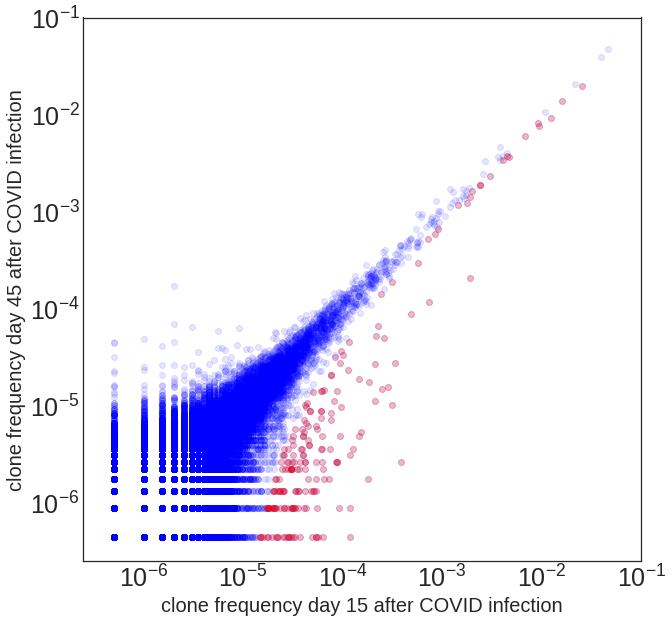

In [ ]:
#Scatter plots of contracted clones
plt.figure(figsize=(10,10))

plt.style.use('seaborn-white')
plt.scatter(df_contraction['Clone_fraction_2'], df_contraction['Clone_fraction_1'], color = 'blue', alpha = 0.1)
plt.scatter(table_expansion['$f_2$'], table_expansion['$f_1$'], color = 'red', alpha = 0.2)

plt.xlabel(r'clone frequency day 15 after COVID infection', fontsize=20)
plt.ylabel(r'clone frequency day 45 after COVID infection', fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.axis([2.5e-7, 1e-1, 2.5e-7, 1e-1])

### 3.3 Validating the identified clonotypes

In this part, we want to check that clonotypes detected by NoisET are actually biologically relevant. To do so, we can verify that there is a significant overlap between them and the open-access database of TCR from : https://clients.adaptivebiotech.com/pub/covid-2020 known to interact with SARS-Cov2 antigen. (Here the paper describing this data https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7418734/)

Let's import the table! 

In [ ]:
def import_mira_clones(path):
  mira_clones = pd.read_csv(path).loc[:,['TCR BioIdentity']]
  uniques = set(mira_clones['TCR BioIdentity'])
  mira_clones = pd.DataFrame(list(uniques), columns=['TCR BioIdentity'])
  mira_clones['aaCDR3'] = mira_clones['TCR BioIdentity'].str.split('+').str[0]
  mira_clones['Vgene'] = mira_clones['TCR BioIdentity'].str.split('+').str[1]
  mira_clones['Jgene'] = mira_clones['TCR BioIdentity'].str.split('+').str[2]
  return mira_clones.drop('TCR BioIdentity', axis=1)

mira_cl = import_mira_clones('/content/NoisET_tutorial/data/MIRA_clonotypes.csv')['aaCDR3'].values
print('Number of clonotypes in the MIRA database:', len(mira_cl))

Number of clonotypes in the MIRA database: 142069


We are going to use the aminoacid sequences instead of the nucleotide ones (it's faster to compare amino-acid than nucleotide strings).
For counting the overlap between two lists of sequences, we are going to use an external software. Below its installation. (This software enables to compare in a reasonable amount of time two lists of aminoacid sequences).

In [ ]:
!pip install '/content/NoisET_tutorial/ATrieGC/'

import atriegc

Processing ./NoisET_tutorial/ATrieGC
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for atriegc: filename=atriegc-0.0.1-cp37-cp37m-linux_x86_64.whl size=899839 sha256=ad04c63db0e1f5c06512a6a55b454a49412b92eb9bd91f267780f49ea3ffe24c
  Stored in directory: /tmp/pip-ephem-wheel-cache-6nxro02i/wheels/ff/94/96/da7a87b7d6d9bcc7c845c9f04b3da98cc6476a19f66c566e46
Successfully built atriegc


Now we can count how many clonotypes of our noiset list are also present in the mira list.

In [ ]:
def build_shared_clones(mira_clones, clones, h_dist):
    # Finding matches between amino-acid sequences given Hamming distance
    trie = atriegc.TrieAA()
    trie.insert_list(mira_clones)        
    shared_clones = trie.shared_elements(clones, h_dist) 
    # Building dictionary {candidate_clonotype : list_of_mira_clnotype_matches}
    shared_clones_d = dict()
    for [cl_mira, cl] in shared_clones:
        if cl not in shared_clones_d:
            shared_clones_d[cl] = [cl_mira]
        else:
            shared_clones_d[cl].append(cl_mira)
    return shared_clones_d

noiset_cl = table_expansion['CDR3_AA'].values
shared_clones = build_shared_clones(mira_cl, noiset_cl, 0)
noiset_overlap = len(shared_clones)/len(noiset_cl)
print('The overlap between the two lists is:', noiset_overlap)

The overlap between the two lists is: 0.09183673469387756


To asses that our method works, we also need to compare this number with a "dummy" way of selecting interesting clonotypes, i.e. by sampling at random.

In the following we generate at random a lot of different samples, compute the average overlap and its standard deviation.
Given these two number we can compute a z-score (https://en.wikipedia.org/wiki/Standard_score) to quantify how much our method deviates from the dummy one.



In [ ]:
all_aa_seqs = list(df_contraction['AACDR3'])

n_trials = 100
overlaps = []
for _ in range(n_trials):
  sample = np.random.choice(all_aa_seqs, len(noiset_cl), replace=False)
  shared_clones = build_shared_clones(mira_cl, sample, 0)
  overlaps.append(len(shared_clones)/len(noiset_cl))

In [ ]:
z = abs(noiset_overlap-np.mean(overlaps))/np.std(overlaps)
print(z)

7.864454866654799
